<a href="https://colab.research.google.com/github/morganmcg1/reformer-fastai/blob/main/experiments/LM_exp_template_wandb_AdaFactor_BPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
if 'google.colab' in sys.modules:
  !pip install -Uqq fastai einops datasets wandb yappi gprof2dot pyinstrument

     |████████████████████████████████| 194kB 13.8MB/s 
     |████████████████████████████████| 163kB 26.2MB/s 
     |████████████████████████████████| 1.8MB 27.8MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 17.7MB 268kB/s 
     |████████████████████████████████| 245kB 50.8MB/s 
     |████████████████████████████████| 163kB 51.2MB/s 
     |████████████████████████████████| 133kB 58.7MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 


Note: Restart the runtime after installing fastai

## Download the tranformer and tokenizer code

In [1]:
!git clone https://github.com/morganmcg1/reformer-fastai.git
%cd reformer-fastai

## Download and Unpack enwik8 Data

Download and unzip enwik8 data


In [2]:
!wget -P data/ http://mattmahoney.net/dc/enwik8.zip
!unzip data/enwik8.zip -d data/
!ls data
!head -n 132 data/enwik8

--2020-12-04 18:42:10--  http://mattmahoney.net/dc/enwik8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36445475 (35M) [application/zip]
Saving to: ‘data/enwik8.zip’

enwik8.zip          100%[===================>]  34.76M   721KB/s    in 51s     

2020-12-04 18:43:01 (705 KB/s) - ‘data/enwik8.zip’ saved [36445475/36445475]

Archive:  data/enwik8.zip
  inflating: data/enwik8             
enwik8	enwik8.zip
<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd" version="0.3" xml:lang="en">
  <siteinfo>
    <sitename>Wikipedia</sitename>
    <base>http://en.wikipedia.org/wiki/Main_Page</base>
    <generator>MediaWiki 1.6alpha</generator>
    <case>first-letter</case>
      <na

## Actual start of the experiment

In [3]:
import sys
import six
from fastai.text.all import *

In [4]:
from basic_tokenizers import ByteTextTokenizer
from basic_transformer import TransformerLM
from make_dataset import read_and_prepare_data

No module named 'axial_positional_embedding'


## Experiment Tracking

Make sure you have wandb and are logged in:

In [5]:
!wandb login <your_identifier>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Load Experiment Tracking with Weights & Biases:

## Wandb experiment logging
Suggeted [wandb.init logging](https://docs.wandb.com/library/init) to help keep track of experiments:

**WANDB_NAME**

A specific name for a particular experiment, e.g. "lsh_2_hash_enwik8"

**GROUP**

Group identifiers will help organise and **group experiments together** in the wandb interface. Suggested identifier to use are:

- "TEST" : for general testing
- "SHARED-QK" : for Shared Query-Key experiments
- "LSH" : LSH-related experiemnts
- "REVERSIBLE" : reversible layers experiments
- "WMT" : for the WMT task

**NOTES**

A longer description of the run, like a -m commit message in git. This helps you remember what you were doing when you ran this run.

**CONFIG**

A dictionary-like object for saving inputs to your job, like hyperparameters for a model or settings for a data preprocessing job. The config will show up in a table in the UI that you can use to group, filter, and sort runs. Keys should not have . in the names, and values should be under 10 MB.

**TAGS**

A list of strings, which will populate the list of tags on this run in the UI. Tags are useful for organizing runs together, or applying temporary labels like "baseline" or "production". It's easy to add and remove tags in the UI, or filter down to just runs with a specific tag.

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'enc_lm_enwik8'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing the encoder LM model works'
CONFIG = {}
TAGS =['enc_lm','test']

Initialise wandb logging, pleaes **do not change** `project` or `entity` (that that everything gets logged to the same place)

# Read & Prepare Data

In [ ]:
# df has columns [text, lens, lens_cum_sum], add a numerical seq_length argument
# to the function below if you'd like to split the data into samples with that seq length
df = read_and_prepare_data('data/enwik8')

Load tokenizer

In [9]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

In [10]:
# # Patch the LMDataloader
# @patch
# def create_item(self:LMDataLoader, seq):
#     if seq>=self.n: raise IndexError
#     sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
#     st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
#     txt = self.chunks[st : st+sl+1]    
#     return LMTensorText(txt[:-1]),txt[1:]
#     # return LMTensorText(txt[:-1].tolist()+[1]), LMTensorText(txt[1:].tolist()+[1])   ## ADD EOS TOKEN

Calc splits

In [11]:
# Back up the original dataframe
df_bckp=df

In [12]:
# Take 4000 records for sake of performance
df=df_bckp[:4000]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
dtypes: object(1)
memory usage: 31.4+ KB


In [15]:
train_cutoff = int(df.lens.sum()*0.5) #- 10000000  # keep all but 10M characters for val and test
    
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

In [16]:
len(train_idxs),len(validation_idxs)

(2253, 874)

Get dls

In [17]:
# Quick naive split alternative
# cut = int(len(df)*0.8)
# splits = range_of(df)[:cut], range_of(df[cut:])

tfms = [attrgetter("text"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

vocab_sz = bte.vocab_size
bs,sl = 32,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

In [18]:
## Yappi - Profiler 1
#import yappi
#yappi.start()

In [19]:
# Profiler 2
#from pyinstrument import Profiler

#profiler = Profiler()
#profiler.start()

In [20]:
dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq)

In [21]:
# Profiler 2
#profiler.stop()

In [22]:
# Profiler 2
#print(profiler.output_text(unicode=True, color=True))

In [23]:
## Yappi - Profiler 1
#func_stats = yappi.get_func_stats()
#func_stats.save('callgrind.out', 'CALLGRIND')
#yappi.stop()
#yappi.clear_stats()

In [24]:
## Yappi - Profiler 1
#!gprof2dot -f callgrind -n10 -s callgrind.out > valgrind.dot
#!dot -Tpng valgrind.dot -o valgrind.png

In [25]:
dls.show_batch(max_n=2)

,text,text_
0,"<bos> <namespace key=""11"">Template talk</namespace>\n<eos><bos>* [http://www.spe.org/society/abudhabi/AbuDhabi-info.htm SPE history, wit","<namespace key=""11"">Template talk</namespace>\n<eos><bos>* [http://www.spe.org/society/abudhabi/AbuDhabi-info.htm SPE history, with"
1,"or abnormal functioning in at least one of the following areas, with onset prior to age 3 years: (1) social interaction, (2) la","or abnormal functioning in at least one of the following areas, with onset prior to age 3 years: (1) social interaction, (2) lan"


In [26]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

((32, 128), (32, 128))

In [27]:
vocab_sz = bte.vocab_size

# Begin Experiment Training

In [28]:
from fastai.callback.wandb import *

In [29]:
wandb.login()

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


True

In [41]:
wandb.init(reinit=True, project="reformer-fastai", name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

In [45]:
import math

class BPC(AvgLoss):
    "Bit per character for Language Models"
    @property
    def value(self): return (self.total/self.count*math.log(2)) if self.count != 0 else None
    @property
    def name(self):  return "bpc"

In [46]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, BPC()])#.to_native_fp16()

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.00013182566908653826)

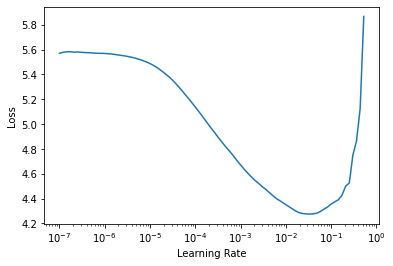

In [39]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(2, 5e-4, wd=0.05,cbs=WandbCallback(log_model=False))

epoch,train_loss,valid_loss,accuracy,bpc,time
0,3.791747,3.692107,0.132286,2.559174,00:10
1,3.605927,3.687805,0.132286,2.556192,00:11


WandbCallback was not able to get prediction samples -> wandb.log must be passed a dictionary


In [ ]:
class Adafactor(torch.optim.Optimizer):
    """Implements Adafactor algorithm.

    This implementation is based on:
    `Adafactor: Adaptive Learning Rates with Sublinear Memory Cost`
    (see https://arxiv.org/abs/1804.04235)

    Note that this optimizer internally adjusts the learning rate
    depending on the *scale_parameter*, *relative_step* and
    *warmup_init* options. To use a manual (external) learning rate
    schedule you should set `scale_parameter=False` and
    `relative_step=False`.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): external learning rate (default: None)
        eps (tuple[float, float]): regularization constans for square gradient
            and parameter scale respectively (default: (1e-30, 1e-3))
        clip_threshold (float): threshold of root mean square of
            final gradient update (default: 1.0)
        decay_rate (float): coefficient used to compute running averages of square
            gradient (default: -0.8)
        mom (float): coefficient used for computing running averages of gradient
            (default: None)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        scale_parameter (bool): if True, learning rate is scaled by root mean square of
            parameter (default: True)
        relative_step (bool): if True, time-dependent learning rate is computed
            instead of external learning rate (default: True)
        warmup_init (bool): time-dependent learning rate computation depends on
            whether warm-up initialization is being used (default: False)
    """

    def __init__(
        self,
        params,
        lr=None,
        eps=(1e-30, 1e-3),
        clip_threshold=1.0,
        decay_rate=-0.8,
        mom=None,
        weight_decay=0.0,
        scale_parameter=True,
        relative_step=True,
        warmup_init=False,
    ):
        if lr is not None and relative_step:
            raise ValueError("Cannot combine manual lr and relative_step options")
        if warmup_init and not relative_step:
            raise ValueError("warmup_init requires relative_step=True")

        defaults = dict(
            lr=lr,
            eps=eps,
            clip_threshold=clip_threshold,
            decay_rate=decay_rate,
            mom=mom,
            weight_decay=weight_decay,
            scale_parameter=scale_parameter,
            relative_step=relative_step,
            warmup_init=warmup_init,
        )
        super(Adafactor, self).__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self):
        return True

    @property
    def supports_flat_params(self):
        return False

    def _get_lr(self, param_group, param_state):
        rel_step_sz = param_group["lr"]
        if param_group["relative_step"]:
            min_step = (
                1e-6 * param_state["step"] if param_group["warmup_init"] else 1e-2
            )
            rel_step_sz = min(min_step, 1.0 / math.sqrt(param_state["step"]))
        param_scale = 1.0
        if param_group["scale_parameter"]:
            param_scale = max(param_group["eps"][1], param_state["RMS"])
        return param_scale * rel_step_sz

    def _get_options(self, param_group, param_shape):
        factored = len(param_shape) >= 2
        use_first_moment = param_group["mom"] is not None
        return factored, use_first_moment

    def _rms(self, tensor):
        return tensor.norm(2) / (tensor.numel() ** 0.5)

    def _approx_sq_grad(self, exp_avg_sq_row, exp_avg_sq_col):
        r_factor = (
            (exp_avg_sq_row / exp_avg_sq_row.mean(dim=-1, keepdim=True))
            .rsqrt_()
            .unsqueeze(-1)
        )
        c_factor = exp_avg_sq_col.unsqueeze(-2).rsqrt()
        return torch.mul(r_factor, c_factor)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.dtype in {torch.float16, torch.bfloat16}:
                    grad = grad.float()
                if grad.is_sparse:
                    raise RuntimeError("Adafactor does not support sparse gradients.")

                state = self.state[p]
                grad_shape = grad.shape

                factored, use_first_moment = self._get_options(group, grad_shape)
                # State Initialization
                if len(state) == 0:
                    state["step"] = 0

                    if use_first_moment:
                        # Exponential moving average of gradient values
                        state["exp_avg"] = torch.zeros_like(grad)
                    if factored:
                        state["exp_avg_sq_row"] = torch.zeros(grad_shape[:-1]).to(grad)
                        state["exp_avg_sq_col"] = torch.zeros(
                            grad_shape[:-2] + grad_shape[-1:]
                        ).to(grad)
                    else:
                        state["exp_avg_sq"] = torch.zeros_like(grad)

                    state["RMS"] = 0
                else:
                    if use_first_moment:
                        state["exp_avg"] = state["exp_avg"].to(grad)
                    if factored:
                        state["exp_avg_sq_row"] = state["exp_avg_sq_row"].to(grad)
                        state["exp_avg_sq_col"] = state["exp_avg_sq_col"].to(grad)
                    else:
                        state["exp_avg_sq"] = state["exp_avg_sq"].to(grad)

                p_data_fp32 = p.data
                if p.data.dtype in {torch.float16, torch.bfloat16}:
                    p_data_fp32 = p_data_fp32.float()

                state["step"] += 1
                state["RMS"] = self._rms(p_data_fp32)
                group["lr"] = self._get_lr(group, state)

                beta2t = 1.0 - math.pow(state["step"], group["decay_rate"])
                update = (grad ** 2) + group["eps"][0]
                if factored:
                    exp_avg_sq_row = state["exp_avg_sq_row"]
                    exp_avg_sq_col = state["exp_avg_sq_col"]

                    exp_avg_sq_row.mul_(beta2t).add_(
                        update.mean(dim=-1), alpha=1.0 - beta2t
                    )
                    exp_avg_sq_col.mul_(beta2t).add_(
                        update.mean(dim=-2), alpha=1.0 - beta2t
                    )

                    # Approximation of exponential moving average of square of gradient
                    update = self._approx_sq_grad(exp_avg_sq_row, exp_avg_sq_col)
                    update.mul_(grad)
                else:
                    exp_avg_sq = state["exp_avg_sq"]

                    exp_avg_sq.mul_(beta2t).add_(update, alpha=1.0 - beta2t)
                    update = exp_avg_sq.rsqrt().mul_(grad)

                update.div_(
                    (self._rms(update) / group["clip_threshold"]).clamp_(min=1.0)
                )
                update.mul_(group["lr"])

                if use_first_moment:
                    exp_avg = state["exp_avg"]
                    exp_avg.mul_(group["mom"]).add_(update, alpha=1 - group["mom"])
                    update = exp_avg

                if group["weight_decay"] != 0:
                    p_data_fp32.add_(
                        p_data_fp32, alpha=-group["weight_decay"] * group["lr"]
                    )

                p_data_fp32.add_(-update)

                if p.data.dtype in {torch.float16, torch.bfloat16}:
                    p.data.copy_(p_data_fp32)

        return loss

In [ ]:
@delegates(Adafactor.__init__)
def pytorch_Adafactor(param_groups, **kwargs):
    return OptimWrapper(Adafactor([{'params': ps, **kwargs} for ps in param_groups]))


In [ ]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()])#.to_native_fp16()
learn.opt_func=partial(pytorch_Adafactor, weight_decay=0.0)
learn.opt_func

functools.partial(<function pytorch_Adafactor at 0x7f55847c2048>, weight_decay=0.0)

In [ ]:
learn.fit_one_cycle(2, 5e-4,cbs=WandbCallback(log_model=False))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.051103,3.363344,0.209741,28.885628,00:13
1,3.300203,3.008500,0.234016,20.256989,00:13


WandbCallback was not able to get prediction samples -> wandb.log must be passed a dictionary
